In [ ]:
from config import * #some main key parameters needed.
from private_keys import * #import secret keys
from db_functions import * # this is a python file with self-created functions needed to run this notebook
from functions import *
from regionalization import *
from mapping import *
from plotting import *

from set_up_config import CaseConfig, run_case, make_build_caches

Adding REMIND and IMAGE topology using regionalization.py


In [2]:
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT,PROJECT_NAME

('ecoinvent-3.10-cutoff', 'steel_sector_cbam')

Five scenarios in 2C world in the REMIND model are analyzed:
* Plants with secondary EAF wth carbon capture and CO2 storage
* Plants with secondary EAF with H2-DRI
* Plants with secondary EAF with H2-DRI (only using low-carbon hydrogen via solar PV)
* Plants with secondary EAF with EW (elecrification)
* Plants with secondary EAF with EW (elecrification, only low-carbon solar PV power)

In [3]:
"""
CASE EXECUTION FLAGS FOR REMIND IAM
====================

Each prospective steel scenario is controlled by three boolean flags:

1) create_new_steel_db_*
   - True  → (Re)build the Brightway steel database for this scenario
   - False → Do NOT touch BW databases (assumes DB already exists)

2) calc_lca_impacts_*
   - True  → Run LCA calculations and SAVE results to pickle
   - False → LOAD results from existing pickle file

3) contri_*
   - True  → Include contribution analysis (Scope 1/2/3, CBAM splits)
   - False → Skip contribution arrays (faster, smaller pickles)

IMPORTANT:
- `create_new_steel_db_*` ONLY affects database construction
- `calc_lca_impacts_*` controls compute vs. load-from-pickle
- You can load pickles even if `create_new_steel_db_* = False`
- Typical workflow:
    * First run  : create_db=True,  calc_lca=True
    * Later runs : create_db=False, calc_lca=False
"""

# ------------------------------------------------------------------
# Electrowinning (EW, grid-mix electricity)
# ------------------------------------------------------------------
create_new_steel_db_future_ew_remind = True  # build EW database?
calc_lca_impacts_future_ew_remind   =True  # compute LCA or load pickle?
contri_future_ew_remind             = True  # include contribution analysis?

# ------------------------------------------------------------------
# Electrowinning with low-carbon electricity (EW + renewables)
# ------------------------------------------------------------------
create_new_steel_db_future_ew_lc_remind = True
calc_lca_impacts_future_ew_lc_remind   = True
contri_future_ew_lc_remind            = True

# ------------------------------------------------------------------
# Low-carbon steel baseline (e.g. H2-DRI / LC case)
# ------------------------------------------------------------------
create_new_steel_db_future_lc_remind = True   # rebuild DB
calc_lca_impacts_future_lc_remind   = True # recompute LCA
contri_future_lc_remind             = True   # include Scope + CBAM breakdowns

# ------------------------------------------------------------------
# Low-carbon steel baseline (e.g. H2-DRI)
# ------------------------------------------------------------------
create_new_steel_db_future_remind = True
calc_lca_impacts_future_remind   = True
contri_future_remind             = True

# ------------------------------------------------------------------
# BF-BOF + CCS future steel
# ------------------------------------------------------------------
create_new_steel_db_future_ccs_remind = True
calc_lca_impacts_future_ccs_remind   =True
contri_future_ccs_remind             =True


In [4]:
plants_mod_all = pd.read_excel('data\merged_steel_dbs.xlsx')
plants_mod_all['Continent'] = plants_mod_all['Country/Area'].apply(get_continent)
plants_mod_future = plants_mod_all.copy()

valid_future_statuses = [
    'Operating', 'operating',
    'Announced', 'announced',
    'Construction', 'construction',
    'Finalized (research & testing)'
]

plants_mod_future = plants_mod_future[
    plants_mod_future['Capacity operating status'].isin(valid_future_statuses)
]
plants_mod_future['Capacity operating status'].value_counts()

start_year = 1950 #exclude plants where years are before this one
plants_mod_future = plants_mod_future[ (plants_mod_future['Start date']>start_year) & (plants_mod_future['Start date']<=FUTURE_YEAR) ]
plants_mod_future['Start date'].describe()

count     723.000000
mean     1996.835408
std        20.743634
min      1951.000000
25%      1982.000000
50%      2001.000000
75%      2012.000000
max      2033.000000
Name: Start date, dtype: float64

In [5]:
steel_demand_remind_2040_prim = 724.45318
steel_demand_remind_2040_sec = 961.5875094
steel_demand_remind_2040 = steel_demand_remind_2040_prim + steel_demand_remind_2040_sec

factor_sec = steel_demand_remind_2040_sec/plants_mod_future['EAF steel production'].sum()
plants_mod_future['EAF steel production'] *= factor_sec
plants_mod_future['EAF steel production'].sum()

961.5875093999999

In [6]:
cols_prim = ['BOF steel production',
 #'EAF steel production',
 'EAF steel production (DRI, coal)',
 'EAF steel production (DRI, NG)',
 'OHF steel production',
 #'BF production',
 #'DRI production',
'steel production']

factor = steel_demand_remind_2040_prim/plants_mod_future[cols_prim].sum().sum()

plants_mod_future[cols_prim] = plants_mod_future[cols_prim].multiply(factor)
plants_mod_future[cols_prim].sum(),plants_mod_future[cols_prim].sum().sum()

(BOF steel production                663.465777
 EAF steel production (DRI, coal)      0.422144
 EAF steel production (DRI, NG)       37.197017
 OHF steel production                  0.000000
 steel production                     23.368241
 dtype: float64,
 724.45318)

In [ ]:
def transform_ew_lc(plants: pd.DataFrame) -> pd.DataFrame:
    out = plants.copy()
    out["power_classification"] = "renewable"
    return out

def transform_h2dri_lc(plants: pd.DataFrame) -> pd.DataFrame:
    out = plants.copy()
    out["power_classification"] = "renewable" # this also ensures that we only make low-carbon electrolytic hydrogen using solar PV
    return out

CASES = [
    CaseConfig(
        key="future_h2dri_remind",
        steel_method="",
        db_name_out="steel_db_future_remind",
        dict_acts=dict_acts_future_dri,
        create_db=create_new_steel_db_future_remind,
        calc_lca=calc_lca_impacts_future_remind,
        contri=contri_future_remind,
        plants_transform=None,
    ),
    CaseConfig(
        key="future_h2dri_lc_remind",
        steel_method="lc",
        db_name_out="steel_db_future_lc_remind",
        dict_acts=dict_acts_future_dri,
        create_db=create_new_steel_db_future_lc_remind,
        calc_lca=calc_lca_impacts_future_lc_remind,
        contri=contri_future_lc_remind,
        plants_transform=transform_h2dri_lc,
    ),
    CaseConfig(
        key="future_ccs_remind",
        steel_method="ccs",
        db_name_out="steel_db_future_ccs_remind",
        dict_acts=dict_acts_future_ccs,
        create_db=create_new_steel_db_future_ccs_remind,
        calc_lca=calc_lca_impacts_future_ccs_remind,
        contri=contri_future_ccs_remind,
        plants_transform=None,
    ),
    CaseConfig(
        key="future_ew_remind",
        steel_method="ew",
        db_name_out="steel_db_future_ew_remind",
        dict_acts=dict_acts_future_ew,
        create_db=create_new_steel_db_future_ew_remind,
        calc_lca=calc_lca_impacts_future_ew_remind,
        contri=contri_future_ew_remind,
        plants_transform=None,
    ),
    CaseConfig(
        key="future_ew_lc_remind",
        steel_method="ew_lc",
        db_name_out="steel_db_future_ew_lc_remind",
        dict_acts=dict_acts_future_ew,      # same matching dict, only plants differ
        create_db=create_new_steel_db_future_ew_lc_remind,
        calc_lca=calc_lca_impacts_future_ew_lc_remind,
        contri=contri_future_ew_lc_remind,
        plants_transform=transform_ew_lc,
    ),
]


In [8]:
# 0) One-time cleaning of plants (do this once)
plants_mod_future = plants_mod_future[
    ~plants_mod_future["steel_or_iron_production"].str.contains("iron", case=False, na=False)
].copy()

#plants_mod_future = plants_mod_future[:10]

results = {}
caches = None  # <-- only build when needed

# load 2040 alpha value, precalculated in 2_steel_assessment.ipynb
%store -r alpha_fut

for case in CASES:
    print(case.key, case.create_db)

    if case.create_db:
        # Build caches only once, only if we actually need to build a DB
        if caches is None:
            caches = make_build_caches(
                w=w,
                NAME_REF_DB=NAME_REF_DB,
                BIOSPHERE_DB=BIOSPHERE_DB,
                future_db_name="ecoinvent_remind_SSP2-PkBudg1150_2040_base",
                FUTURE_YEAR=FUTURE_YEAR,
                match_year_to_database=match_year_to_database,
                init_model='remind_SSP2-PkBudg1150',
            )

        results[case.key] = run_case(
            plants_future=plants_mod_future,
            case=case,
            caches=caches,
            bw=bw,
            db_name_base='steel_db', #db_name_base=db_name,this is just for export name
            process_import=process_import,
            annotate_exchanges_with_cbam=annotate_exchanges_with_cbam,
            define_scope_cbam=define_scope_cbam,
            create_regionalized_activity=create_regionalized_activity,
            process_exchanges=process_exchanges,
            add_transport_exchanges=add_transport_exchanges,
            match_year_to_database=match_year_to_database,
            country_to_iso2=country_to_iso2,
            calc_lca_impacts_all_plants=calc_lca_impacts_all_plants,
            MY_METHODS=MY_METHODS,
            european_countries=european_countries,
            dict_types=dict_types,
            sum_exchanges_wo_transport=sum_exchanges_wo_transport,
            time_tag="future",
            db_tag='remind',
            alpha= alpha_fut,
            sum_scope_contributions=sum_scope_contributions,
            sum_cbam_contributions=sum_cbam_contributions,
            sum_cbam_contributions_emission_factor=sum_cbam_contributions_emission_factor,
        )

    else:
        # Load results_df from pickle (no caches, no bw db build)
        results[case.key] = calc_lca_impacts_all_plants(
            steel_method=case.steel_method,
            db_name_base="steel_db",
            methods=MY_METHODS,
            calc_lca_impacts=False,   # <-- load
            contri=case.contri,
            start_idx=0,
            european_countries=european_countries,
            dict_types=dict_types,
            sum_exchanges_wo_transport=sum_exchanges_wo_transport,
            time_tag="future",
            db_tag='remind',
        )

# Convenience variables
results_df_future_dri_remind = results["future_h2dri_remind"]
results_df_future_dri_lc_remind = results["future_h2dri_lc_remind"]
results_df_future_ccs_remind = results["future_ccs_remind"]
results_df_future_ew_remind = results["future_ew_remind"]
results_df_future_ew_lc_remind= results["future_ew_lc_remind"]


future_h2dri_remind True
Getting activity data


100%|██████████| 26100/26100 [00:00<00:00, 119129.91it/s]


Adding exchange data to activities


100%|██████████| 803805/803805 [00:20<00:00, 39202.90it/s]


Filling out exchange data


100%|██████████| 26100/26100 [00:02<00:00, 10769.09it/s]


Getting activity data


100%|██████████| 31161/31161 [00:00<00:00, 262932.94it/s]


Adding exchange data to activities


100%|██████████| 914221/914221 [00:32<00:00, 28102.70it/s]


Filling out exchange data


100%|██████████| 31161/31161 [00:01<00:00, 18772.12it/s]


Getting activity data


100%|██████████| 4362/4362 [00:00<00:00, 311567.48it/s]


Adding exchange data to activities


0it [00:00, ?it/s]


Filling out exchange data


100%|██████████| 4362/4362 [00:00<00:00, 4361276.29it/s]

Applying strategy: add_database_name6/666
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.54 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
711 datasets
56092 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\steel_sector_cbam.fd232721bdc6f1e9f65278e28448e7cf\output\db-matching-steel_db_future_remind-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/21/2026 10:05:10
  Finished: 02/21/2026 10:05:11
  Total time elapsed: 00:00:01
  CPU %: 10.30
  Memory %: 17.55
Created database: steel_db_future_remind


Calculating LCA impacts:   0%|          | 0/711 [00:00<?, ?it/s]c:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\functions.py:334: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
Calculating LCA impacts: 100%|██████████| 711/711 [11:20<00:00,  1.05it/s]


hydrogen production, coal gasification ('coal gasification', 100.0, 0) 16.8357410158953 11
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 9.482550042945965 11
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 10.15054960310847 11
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 10.175980600863902 11
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 9.825358655578478 11
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 9.259970362981981 11
hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 9.259970362981981 11
future_h2dri_lc_remind True
Applying strategy: add_database_name6/666
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.77 seconds
Applying strategy: li

Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Title: Writing activities to SQLite3 database:
  Started: 02/21/2026 10:35:33
  Finished: 02/21/2026 10:35:35
  Total time elapsed: 00:00:02
  CPU %: 26.60
  Memory %: 13.76
Created database: steel_db_future_lc_remind


Calculating LCA impacts:   0%|          | 0/711 [00:00<?, ?it/s]c:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\functions.py:334: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
Calculating LCA impacts: 100%|██████████| 711/711 [15:41<00:00,  1.32s/it]


future_ccs_remind True
Applying strategy: add_database_name6/666
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.88 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
711 datasets
56935 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\steel_sector_cbam.fd232721bdc6f1e9f65278e28448e7cf\output\db-matching-steel_db_future_ccs_remind-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/21/2026 11:19:03
  Finished: 02/21/2026 11:19:05
  Total time elapsed: 00:00:01
  CPU %: 9.50
  Memory %: 13.42
Created database: steel_db_future_ccs_remind


Calculating LCA impacts:   0%|          | 0/711 [00:00<?, ?it/s]c:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\functions.py:334: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
Calculating LCA impacts: 100%|██████████| 711/711 [11:22<00:00,  1.04it/s]


hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 9.25997036298199 11
future_ew_remind True
Applying strategy: add_database_name6/666
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.52 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
711 datasets
57070 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\steel_sector_cbam.fd232721bdc6f1e9f65278e28448e7cf\output\db-matching-steel_db_future_ew_remind-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/21/2026 11:48:49
  Finished: 02/21/2026 11:48:51
  Total time elapsed: 00:00:01
  CPU %: 13.60
  Memory %: 12.90
Created database: steel_db_future_ew_remind


Calculating LCA impacts:   0%|          | 0/711 [00:00<?, ?it/s]c:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\functions.py:334: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
Calculating LCA impacts: 100%|██████████| 711/711 [11:58<00:00,  1.01s/it]


hydrogen production, steam methane reforming ('steam methane reforming', 100.0, 1) 9.259970362981983 11
future_ew_lc_remind True
Applying strategy: add_database_name6/666
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.55 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
711 datasets
56334 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\steel_sector_cbam.fd232721bdc6f1e9f65278e28448e7cf\output\db-matching-steel_db_future_ew_lc_remind-unlinked.xlsx


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 02/21/2026 12:17:30
  Finished: 02/21/2026 12:17:31
  Total time elapsed: 00:00:01
  CPU %: 11.20
  Memory %: 12.67
Created database: steel_db_future_ew_lc_remind


Calculating LCA impacts:   0%|          | 0/711 [00:00<?, ?it/s]c:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\functions.py:334: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)
Calculating LCA impacts: 100%|██████████| 711/711 [11:13<00:00,  1.06it/s]


In [9]:
res = sum_electricity_and_hydrogen_from_db(
    db_name="steel_db_future_remind",
    bw=bw,
    h2_electricity_factor_kWh_per_kg=(120/3.6/0.662),  # electrolysis efficiency assumption for 2050
)

print(f"Electricity demand: {res['electricity_TWh']:.1f} TWh")
print(f"Hydrogen demand: {res['hydrogen_Mt']:.2f} Mt H2")
print(f"Electricity for H2: {res['hydrogen_electricity_TWh']:.1f} TWh")
print(f"Total electricity: {res['total_electricity_TWh']:.1f} TWh")


Electricity demand: 971.8 TWh
Hydrogen demand: 47.50 Mt H2
Electricity for H2: 2392.0 TWh
Total electricity: 3363.8 TWh



Scenario: future_h2dri_remind
------------------------------------------------------------
Total GHG emissions (w/o transport):   1222.9 Mt CO2-eq
Total steel production:               1686.0 Mt
Average emissions intensity:            0.73 kg CO2-eq / kg steel


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


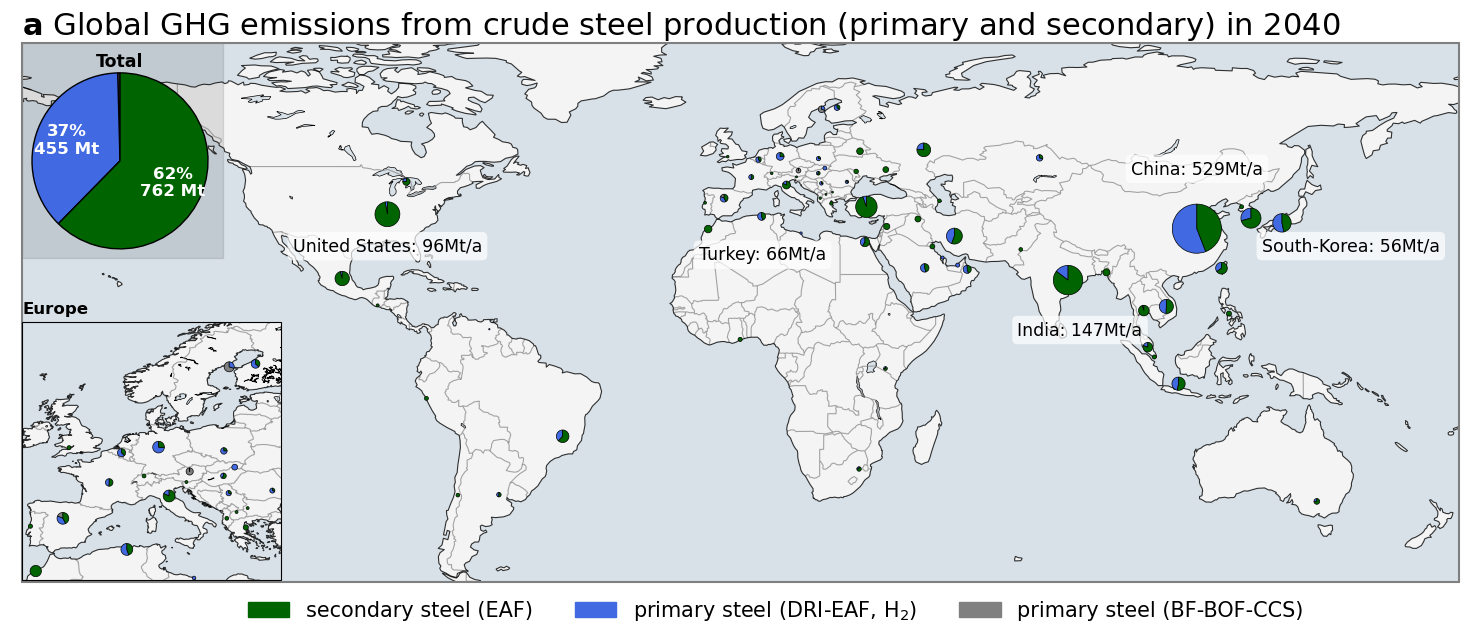

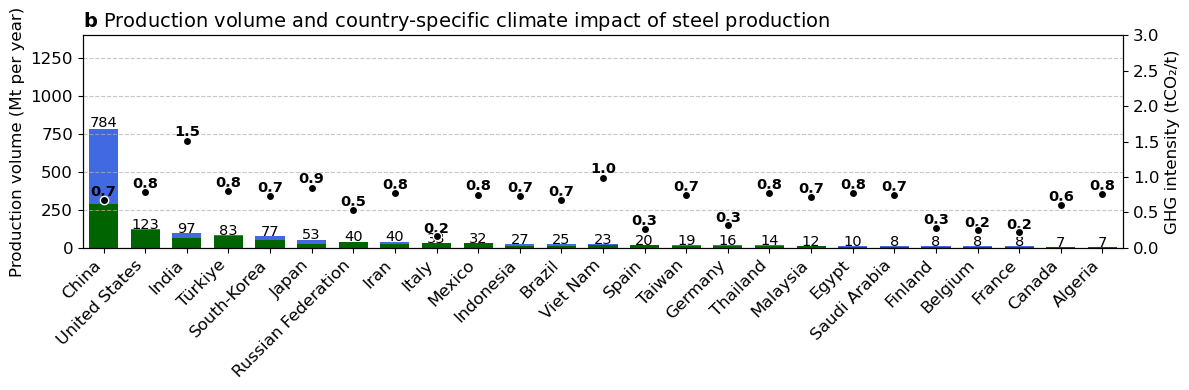


Scenario: future_h2dri_lc_remind
------------------------------------------------------------
Total GHG emissions (w/o transport):   1134.8 Mt CO2-eq
Total steel production:               1686.0 Mt
Average emissions intensity:            0.67 kg CO2-eq / kg steel


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


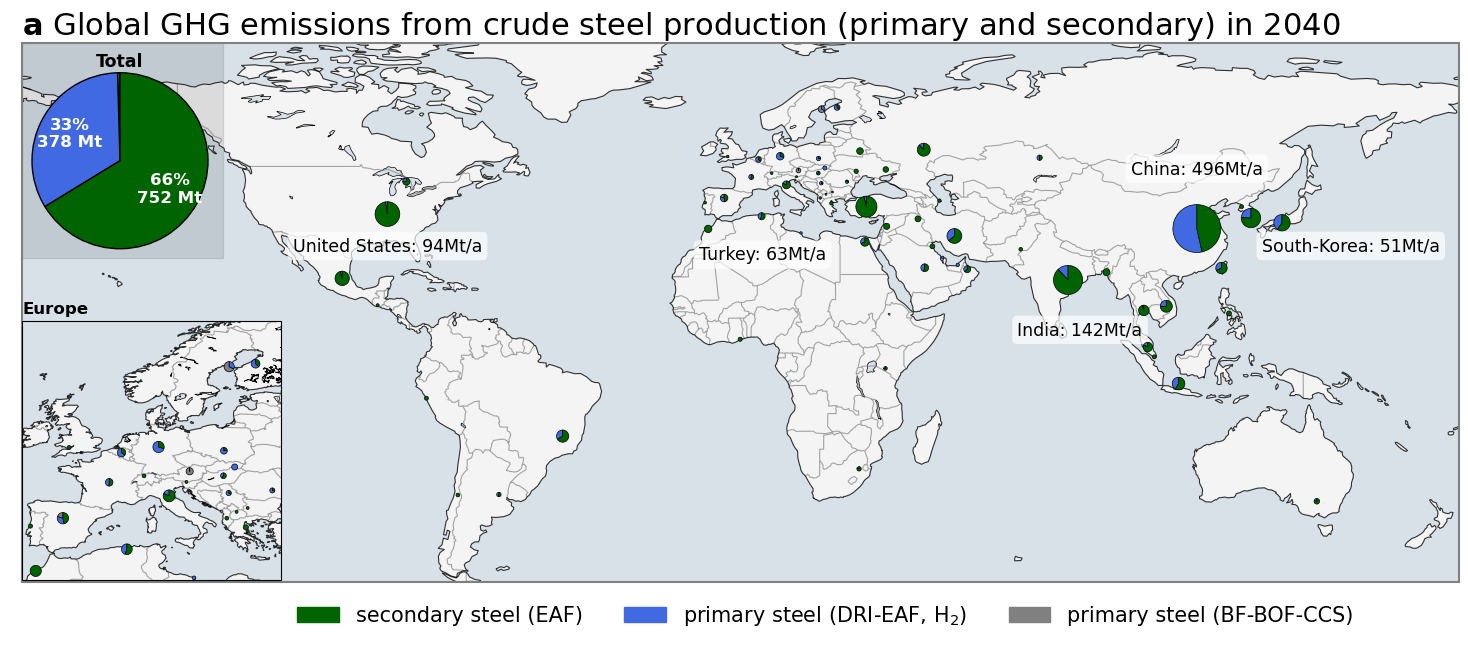

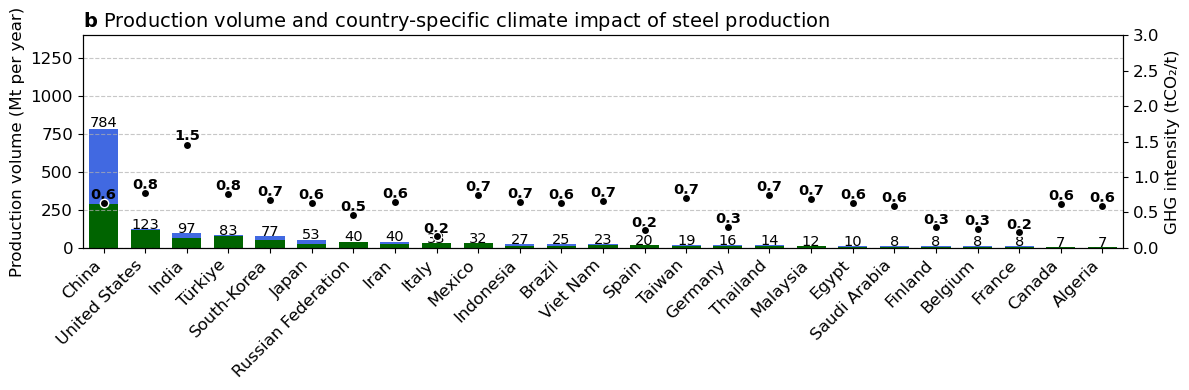


Scenario: future_ccs_remind
------------------------------------------------------------
Total GHG emissions (w/o transport):   1802.3 Mt CO2-eq
Total steel production:               1686.0 Mt
Average emissions intensity:            1.07 kg CO2-eq / kg steel


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


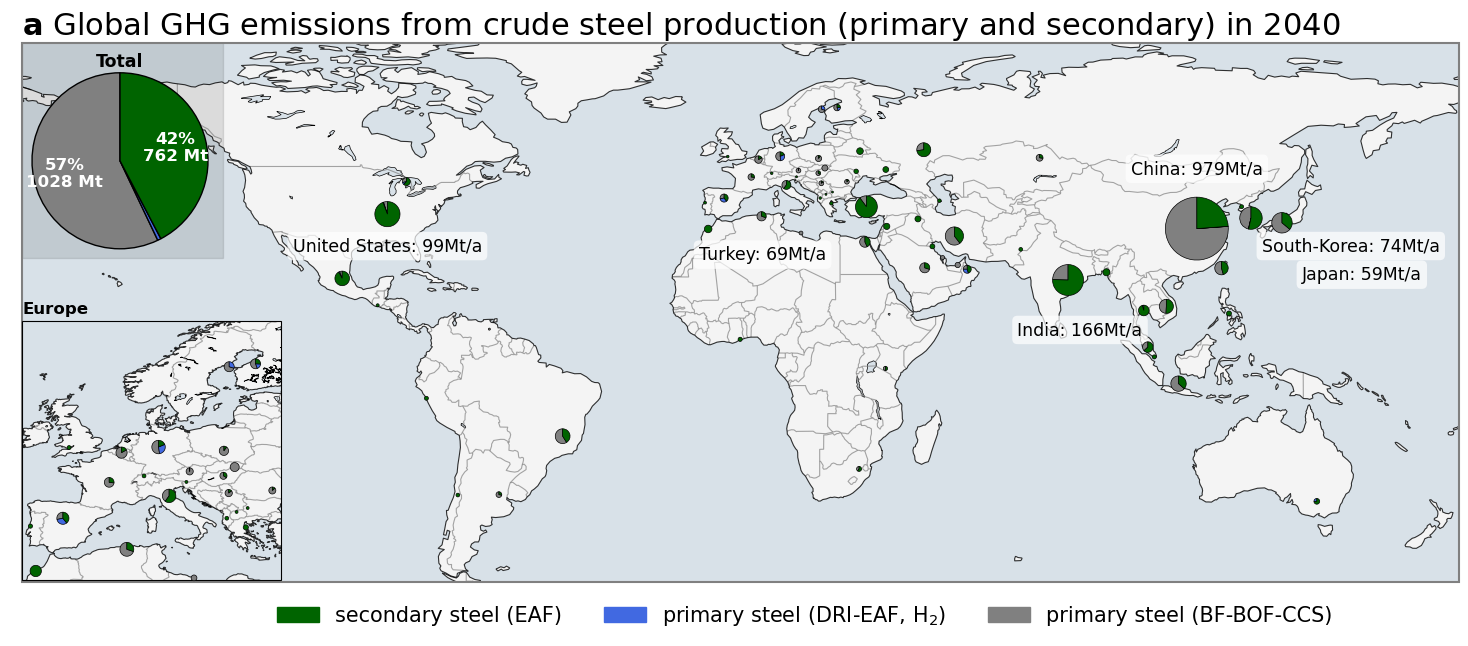

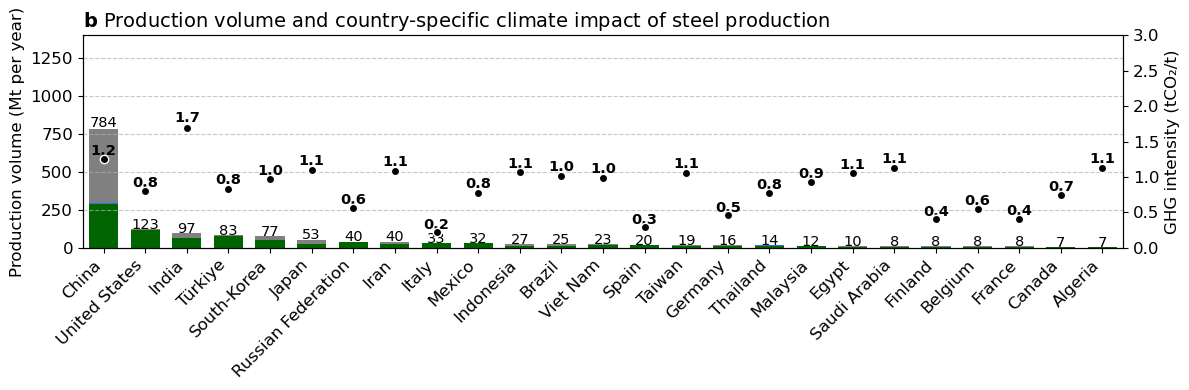


Scenario: future_ew_remind
------------------------------------------------------------
Total GHG emissions (w/o transport):   1340.1 Mt CO2-eq
Total steel production:               1686.0 Mt
Average emissions intensity:            0.79 kg CO2-eq / kg steel


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


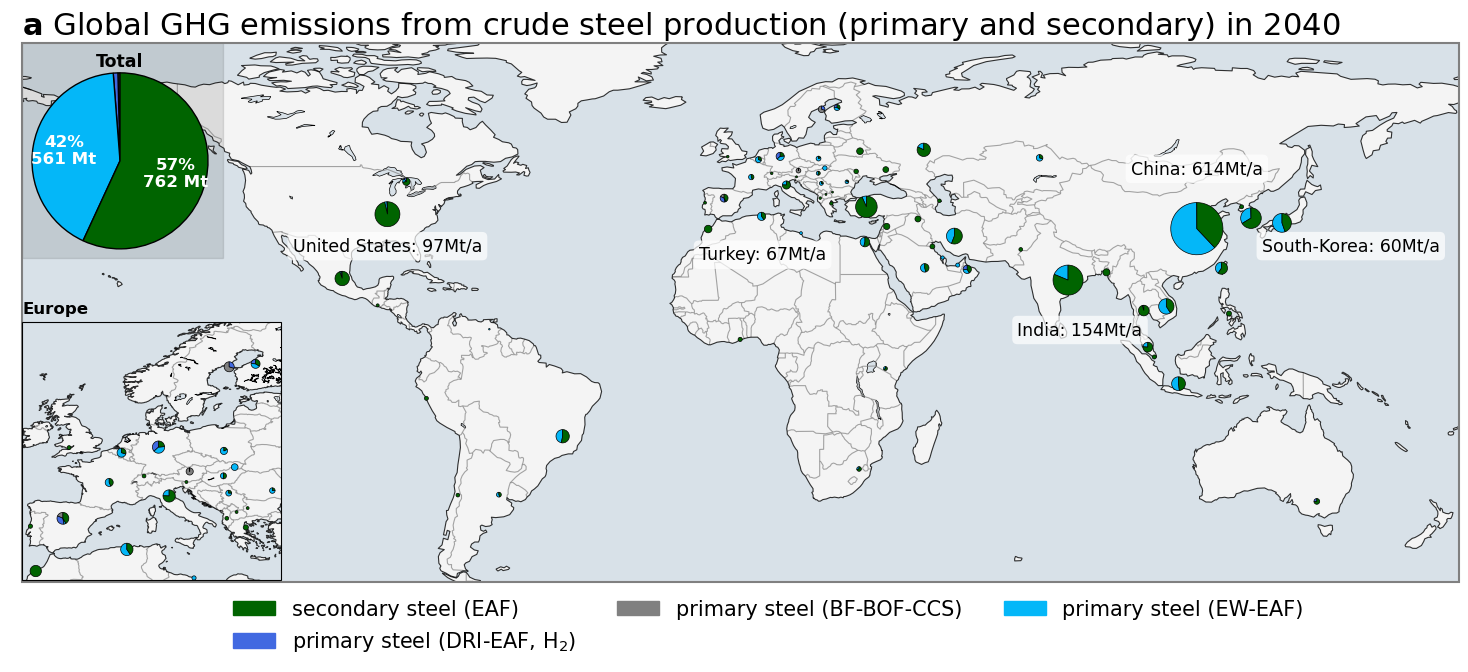

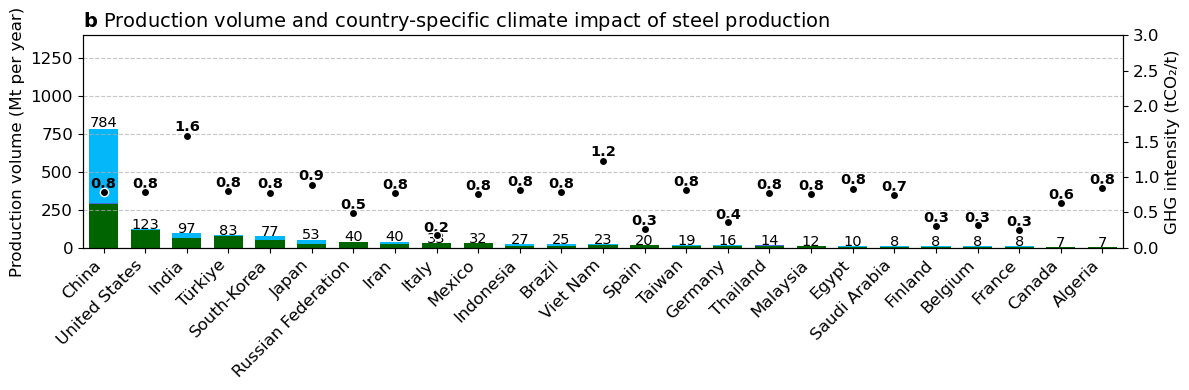


Scenario: future_ew_lc_remind
------------------------------------------------------------
Total GHG emissions (w/o transport):   1250.3 Mt CO2-eq
Total steel production:               1686.0 Mt
Average emissions intensity:            0.74 kg CO2-eq / kg steel


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


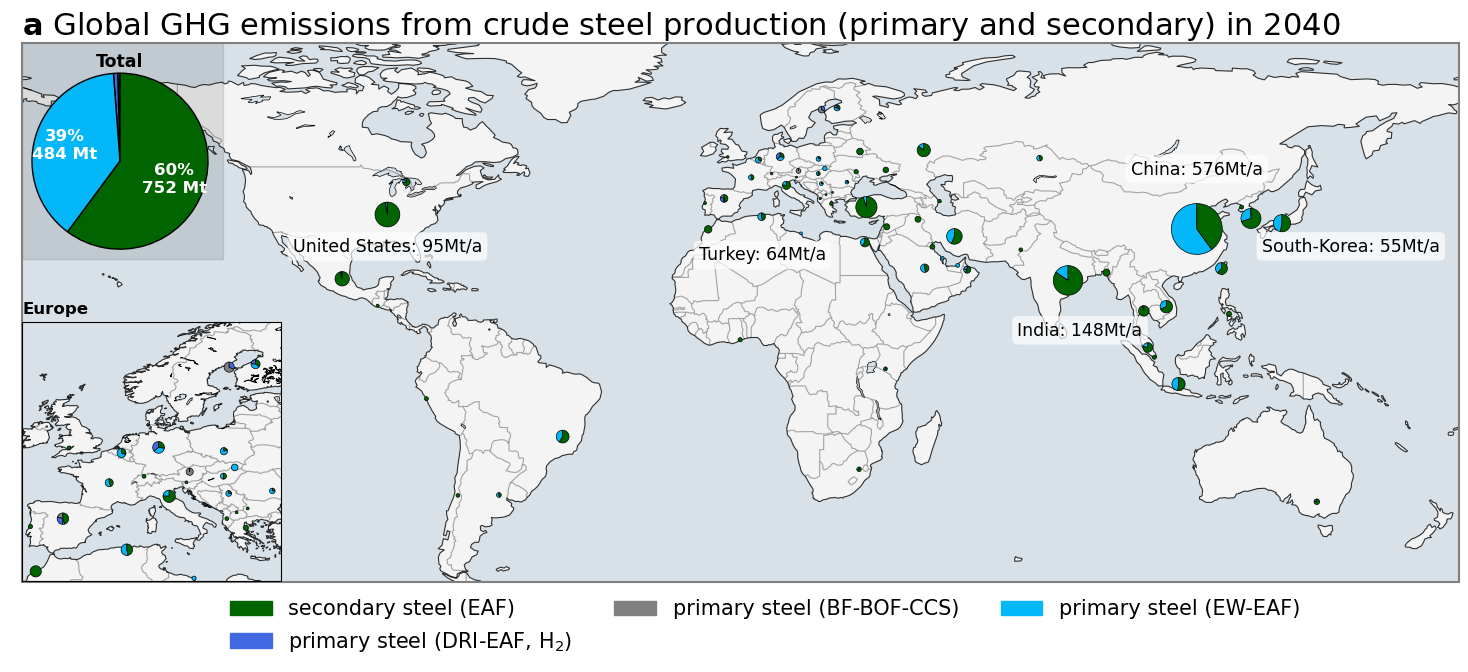

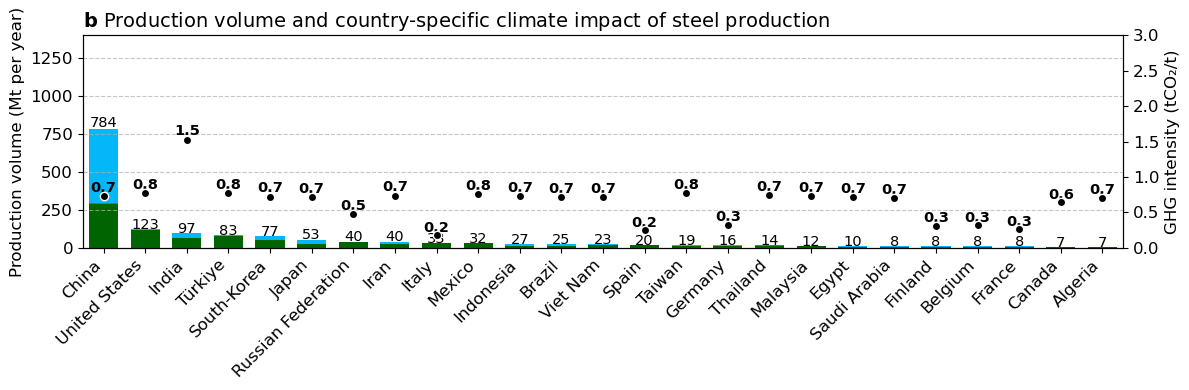

In [10]:
dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (0, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-13, -20),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-7, -25),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-5, -5),
                           'Egypt': (-14, 0)
                          }

pos_legend_false_subplot = [ (150, -15), (150, -15), (100, -10), (130, -13), (130, -13)]

titles = [r'$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary) in 2040']
name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"

for i, (case_key, df) in enumerate(results.items()):
    if df is None or df.empty:
        continue

    # -----------------------------
    # Summary statistics
    # -----------------------------
    total_emissions = df["Plant_GHG_emissions_Mt_wo_transport"].sum()
    total_production = df["production volume"].sum()
    emissions_intensity = (
        total_emissions / total_production
        if total_production > 0 else float("nan")
    )

    print("\n" + "=" * 60)
    print(f"Scenario: {case_key}")
    print("-" * 60)
    print(f"Total GHG emissions (w/o transport): {total_emissions:8.1f} Mt CO2-eq")
    print(f"Total steel production:             {total_production:8.1f} Mt")
    print(f"Average emissions intensity:        {emissions_intensity:8.2f} kg CO2-eq / kg steel")
    print("=" * 60)

    # --- map: GHG emissions ---
    plot_steel_map(
        df,
        [name_to_assess],
        subplot=False,
        titles=titles,
        division_bubble=20,
        amount_show_bubble=50,
        export_figure=f"annual_global_steel_emissions_2040_{case_key}_remind",
        dict_pos=dict_pos,
        pos_legend_false_subplot=pos_legend_false_subplot[i],
    )

    # --- production plot ---
    plot_steel_production(
        df,
        production_col="production volume",
        export_figure=f"prod_fig_intensity_{case_key}_remind",
        max_y=1400,
    )
